In [1]:
import os
import sys
import argparse

import numpy as np
import pandas as pd
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvi
import anndata

import scanpy.external as sce
from scvi.model.utils import mde

from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

import scarches
from scarches.dataset.trvae.data_handling import remove_sparsity
from scarches.models.scpoli import scPoli

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [2]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(8, 8))

In [3]:
adata = sc.read('../../fetal_lung/lung_organoid_epithelial.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 239440 × 65250
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'Cell_type', 'n_counts', 'batch', 'publication'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [5]:
sc.pp.highly_variable_genes(adata,
                            n_top_genes=2000, 
                            batch_key='publication',
                            flavor='seurat_v3', 
                            subset=True)

In [6]:
len(set(adata.obs.publication))

12

In [7]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [ ]:
### DO NOT RUN

scpoli_model = scPoli(
        adata=adata,
        latent_dim= 30,
        unknown_ct_names=['na'],
        condition_keys=['sample_id'],
        cell_type_keys=['level_2'],
        embedding_dims=10,
        hidden_layer_sizes=[512, 512],
        recon_loss='nb'
    )

scpoli_model.train(
    n_epochs=300,
    pretraining_epochs=4,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=100
)

In [ ]:
### DO NOT RUN
scpoli_model.save("models/scpoli_lung_epithelial_organoid_batch_sampleID_30062023_2k")

#### load pre-trained model

In [8]:
model_path = "models/scpoli_lung_epithelial_organoid_batch_sampleID_30062023_2k"
scpoli_model = scarches.models.scpoli.scPoli.load(model_path, adata)

AnnData object with n_obs × n_vars = 239440 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'Cell_type', 'n_counts', 'batch', 'publication'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'ambiguous', 'spliced', 'unspliced'
Embedding dictionary:
 	Num conditions: [50]
 	Embedding dim: [10]
Encoder Architecture:
	Input Layer in, out and cond: 2000 512 10
	Hidden Layer 1 in/out: 512 512
	Mean/Var Layer in/out: 512 30
Decoder Architecture:
	First Layer in, out and cond:  30 512 10
	Hidden Layer 1 in/out: 512 512
	Output Layer in/out:  512 2000 



In [20]:
# add additional metadata, including seq-assay, protocol, aga etc
sample_data = pd.read_table('../../all_samples_sheets.txt')
sample_data.index = sample_data.sample_id
sample_metadata = sample_data.reindex(adata.obs.sample_id.cat.categories)

### Batch embedding

In [23]:
conditional_embeddings = scpoli_model.get_conditional_embeddings()
conditional_embeddings

AnnData object with n_obs × n_vars = 50 × 10

In [24]:
mdata = adata.obs
mdata.index = mdata['sample_id'].values
mdata.drop_duplicates(subset = ['sample_id'] ,inplace=True)

In [25]:
dup_attr = ['publication','sample','sample_id']
sample_metadata.drop(columns = dup_attr, inplace=True)
mdata = pd.concat((mdata, sample_metadata), axis = 1)

In [26]:
conditional_embeddings.obs = mdata

In [27]:
sc.pp.pca(conditional_embeddings)

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


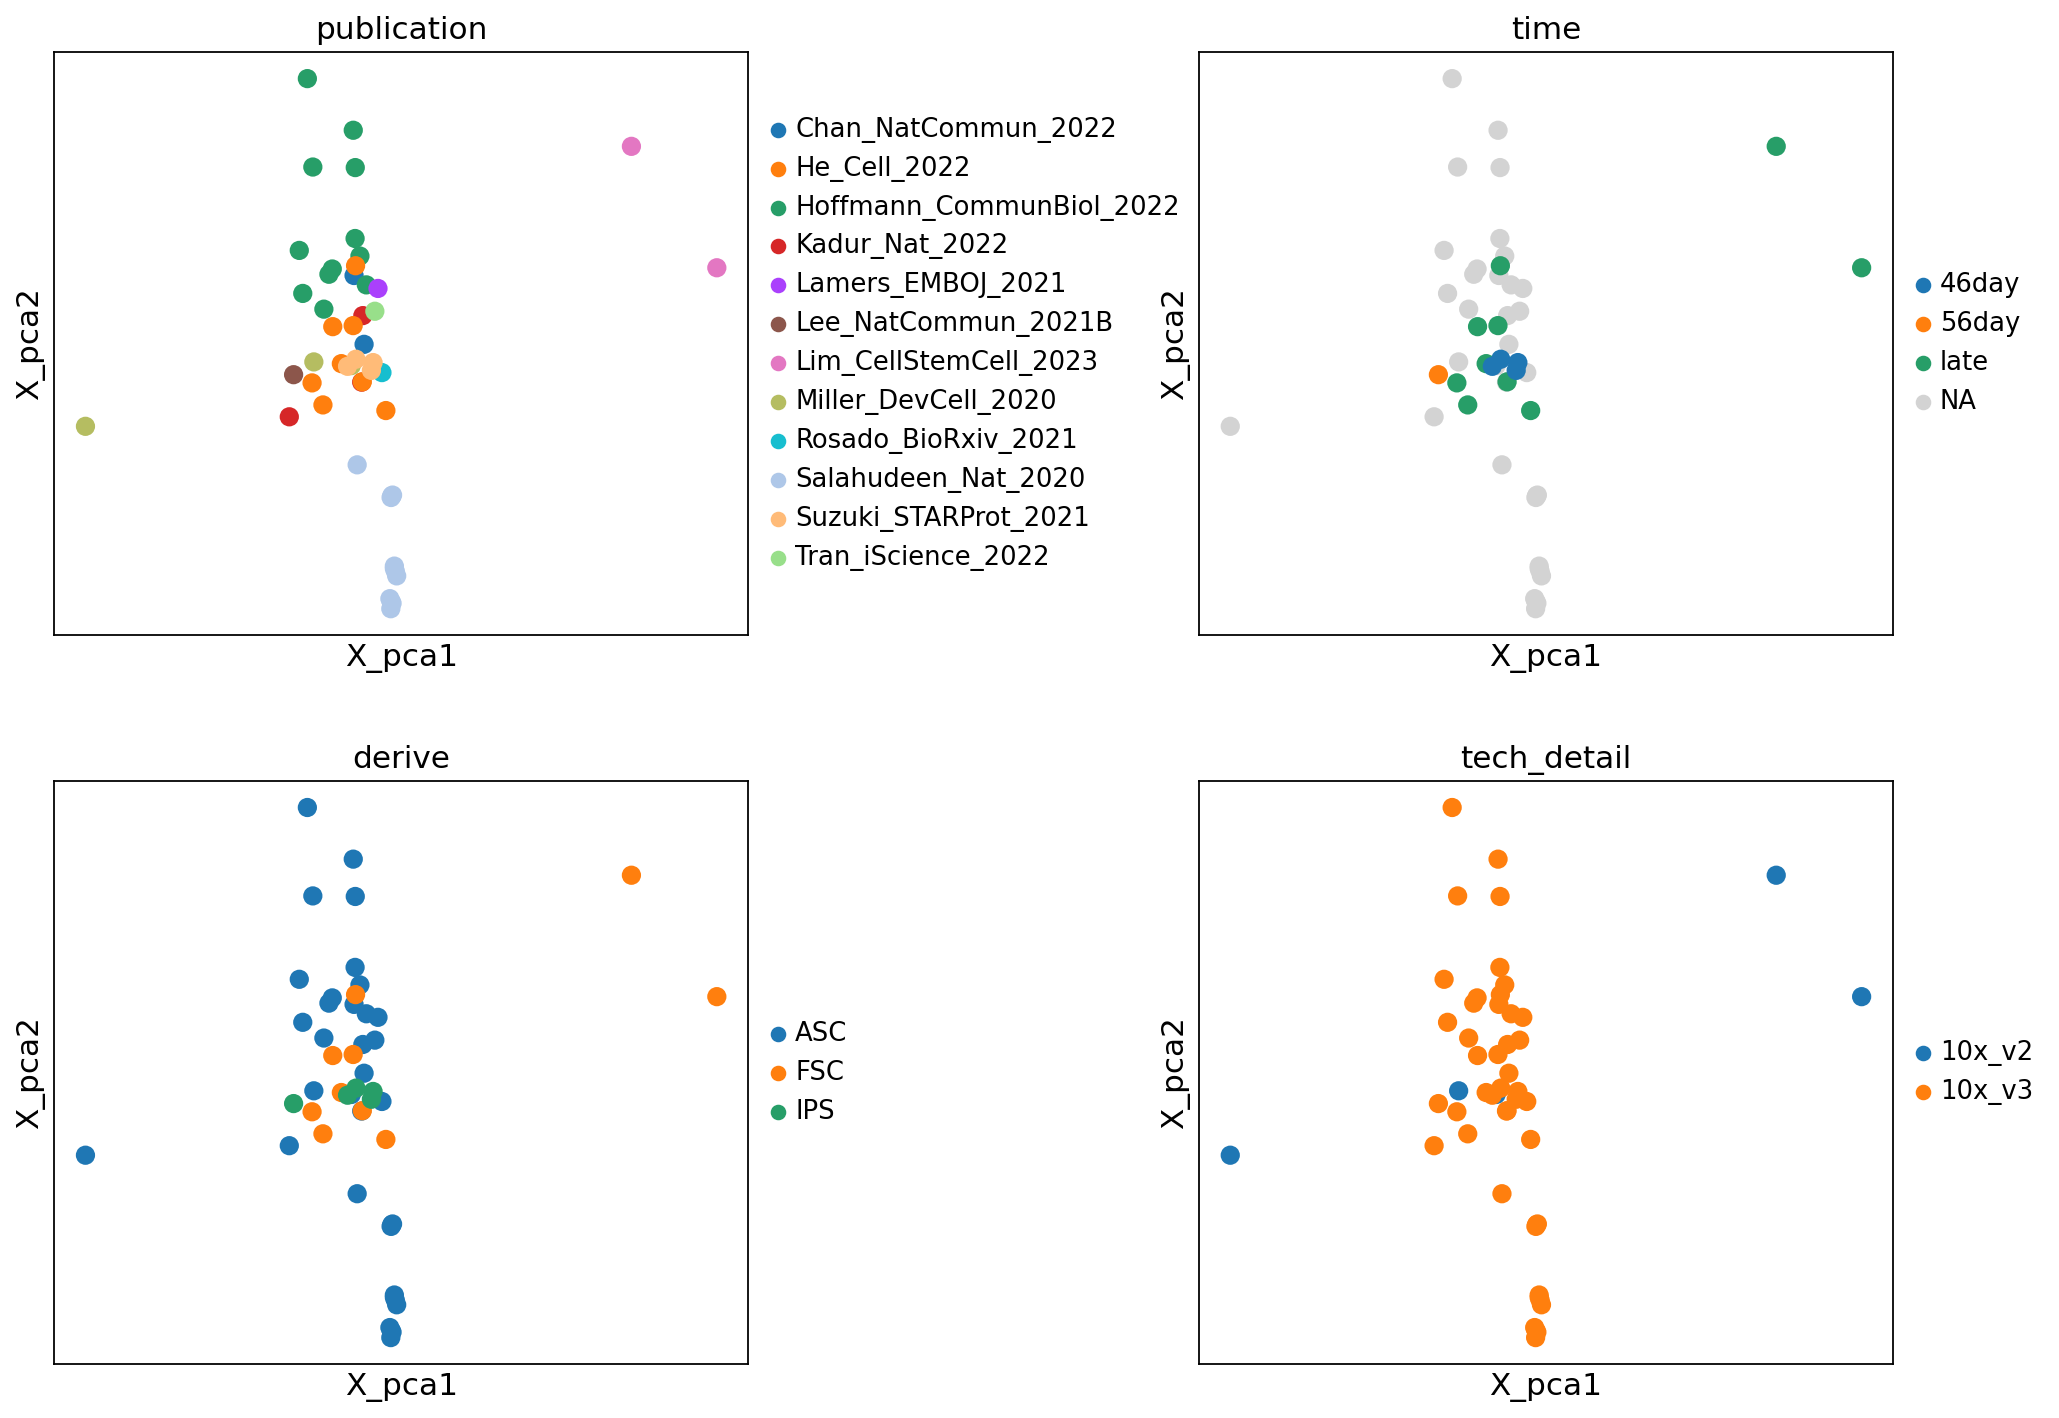

In [28]:
sc.set_figure_params(figsize=(5, 5))

sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['1,2'],
          color=['publication','time','derive','tech_detail'], 
                size = 300,
#           ncols=4, 
          ncols=2, 
                legend_fontsize='small',
          wspace = 0.5,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


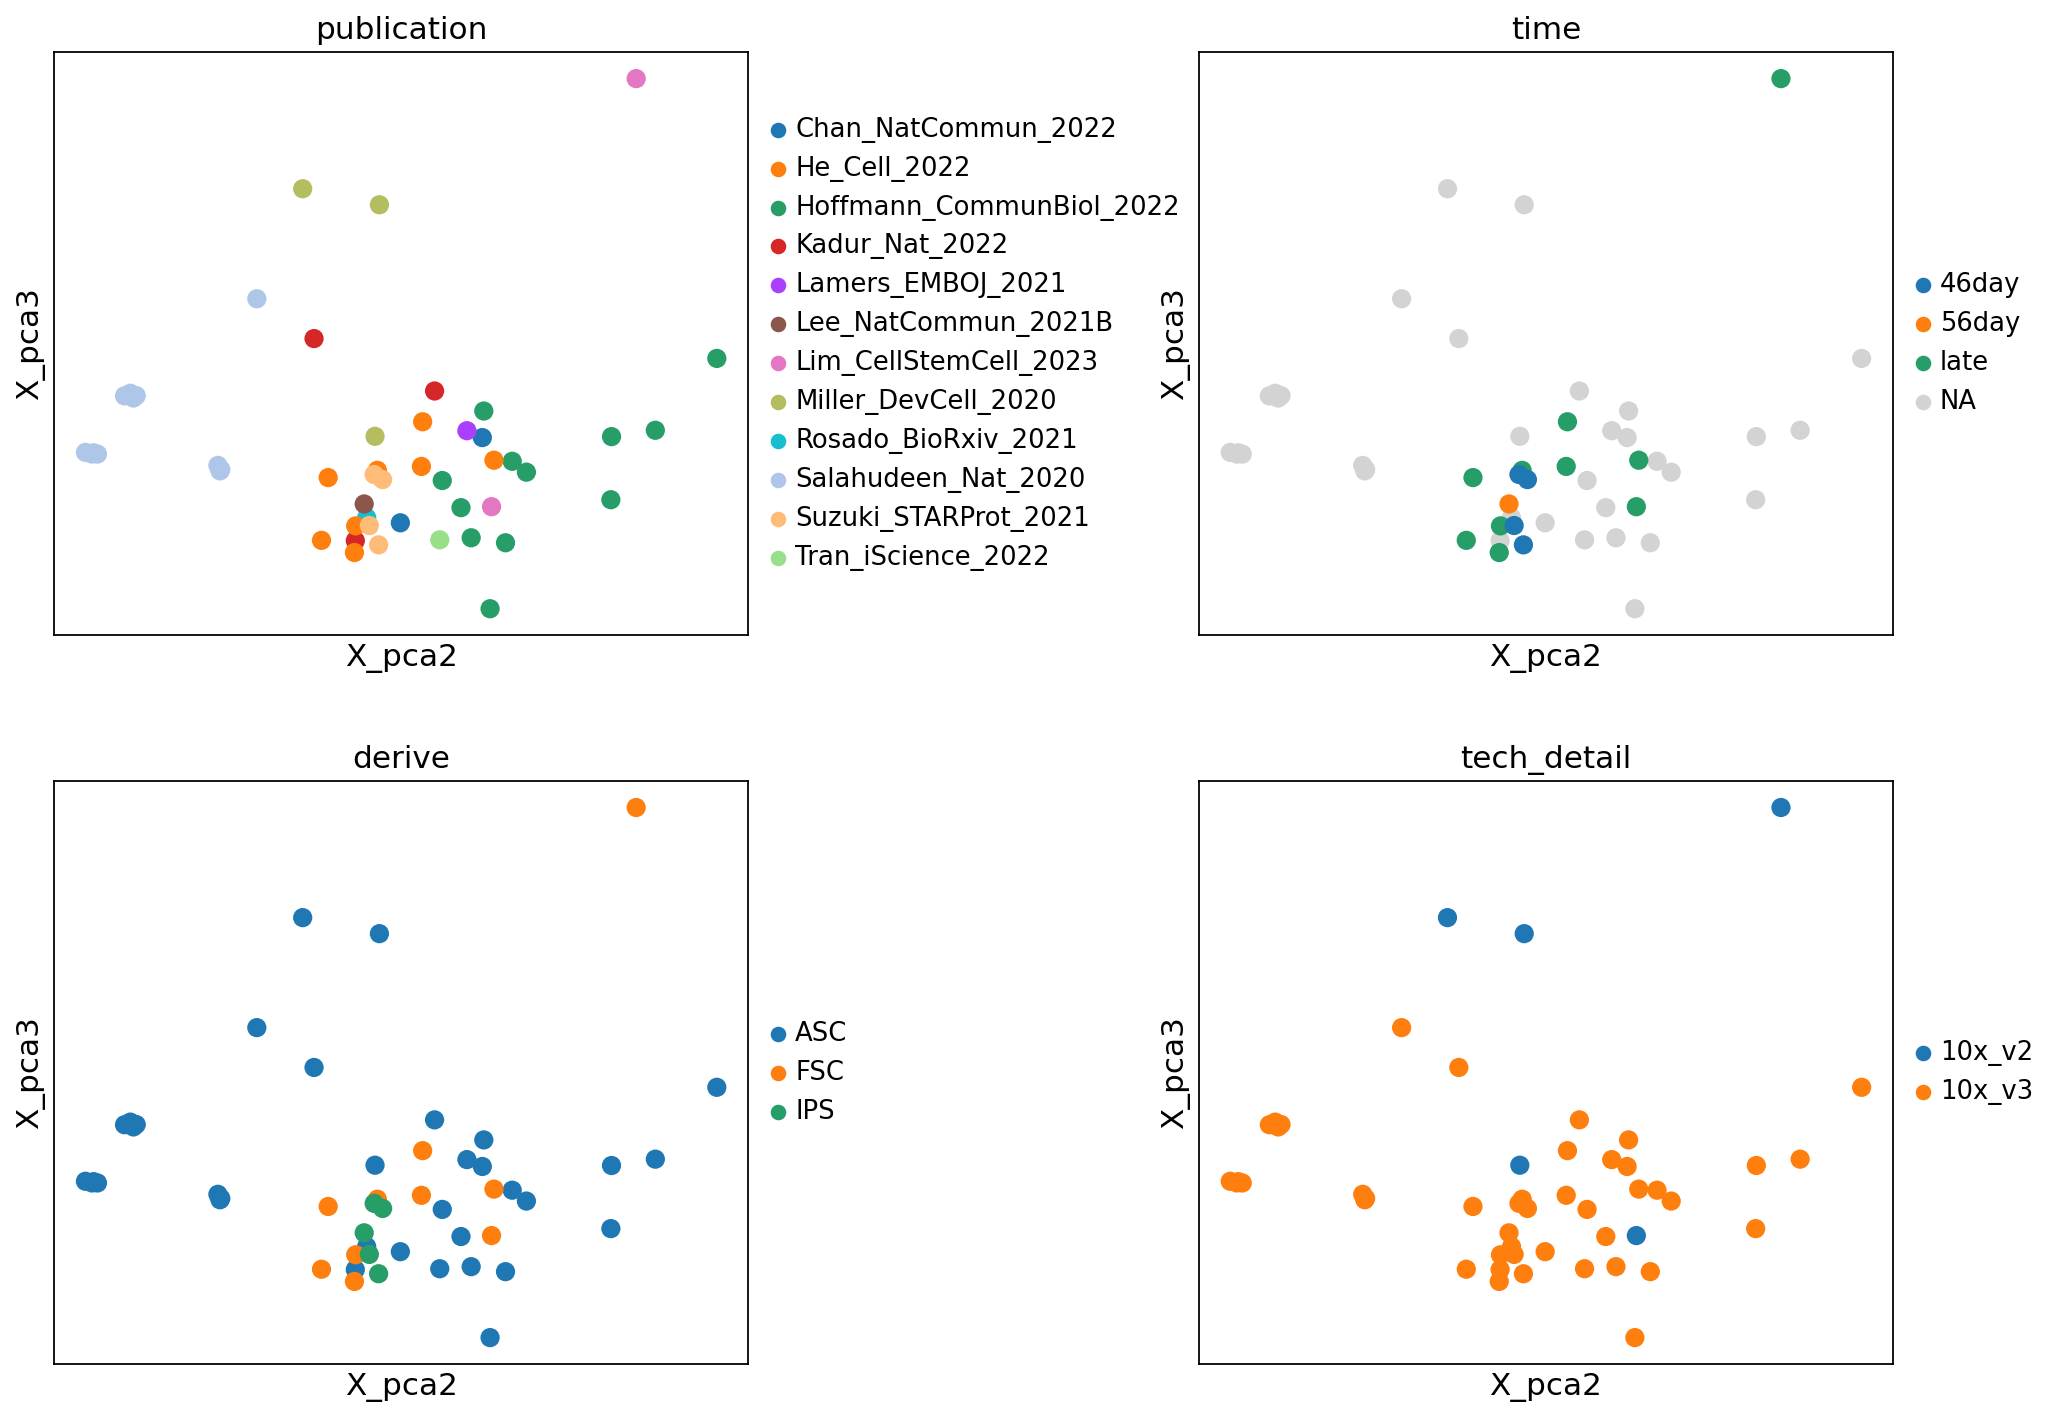

In [29]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['2,3'],
          color=['publication','time','derive','tech_detail'], 
                size = 300,
#           ncols=4, 
          ncols=2, 
                legend_fontsize='small',
          wspace = 0.5,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


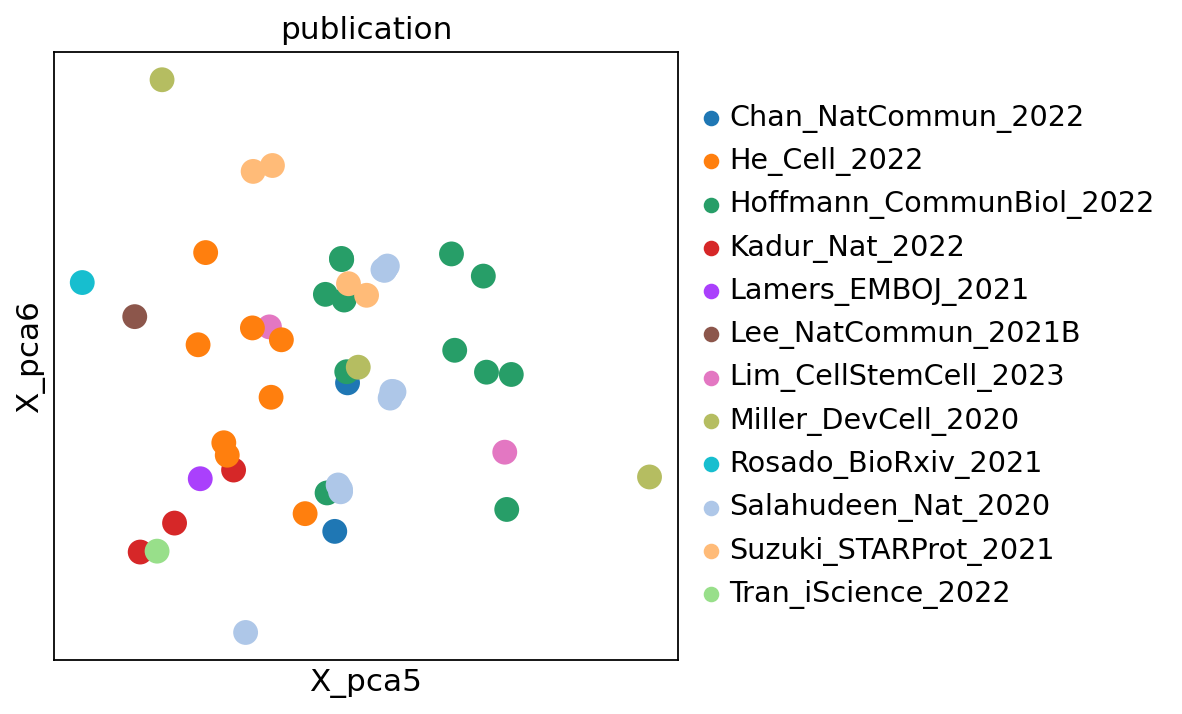

In [30]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['5,6'],
          color=['publication',], 
                size = 500,
#           ncols=4, 
          ncols=1, 
#                 legend_fontsize='x-small'
#           wspace = 0.75,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


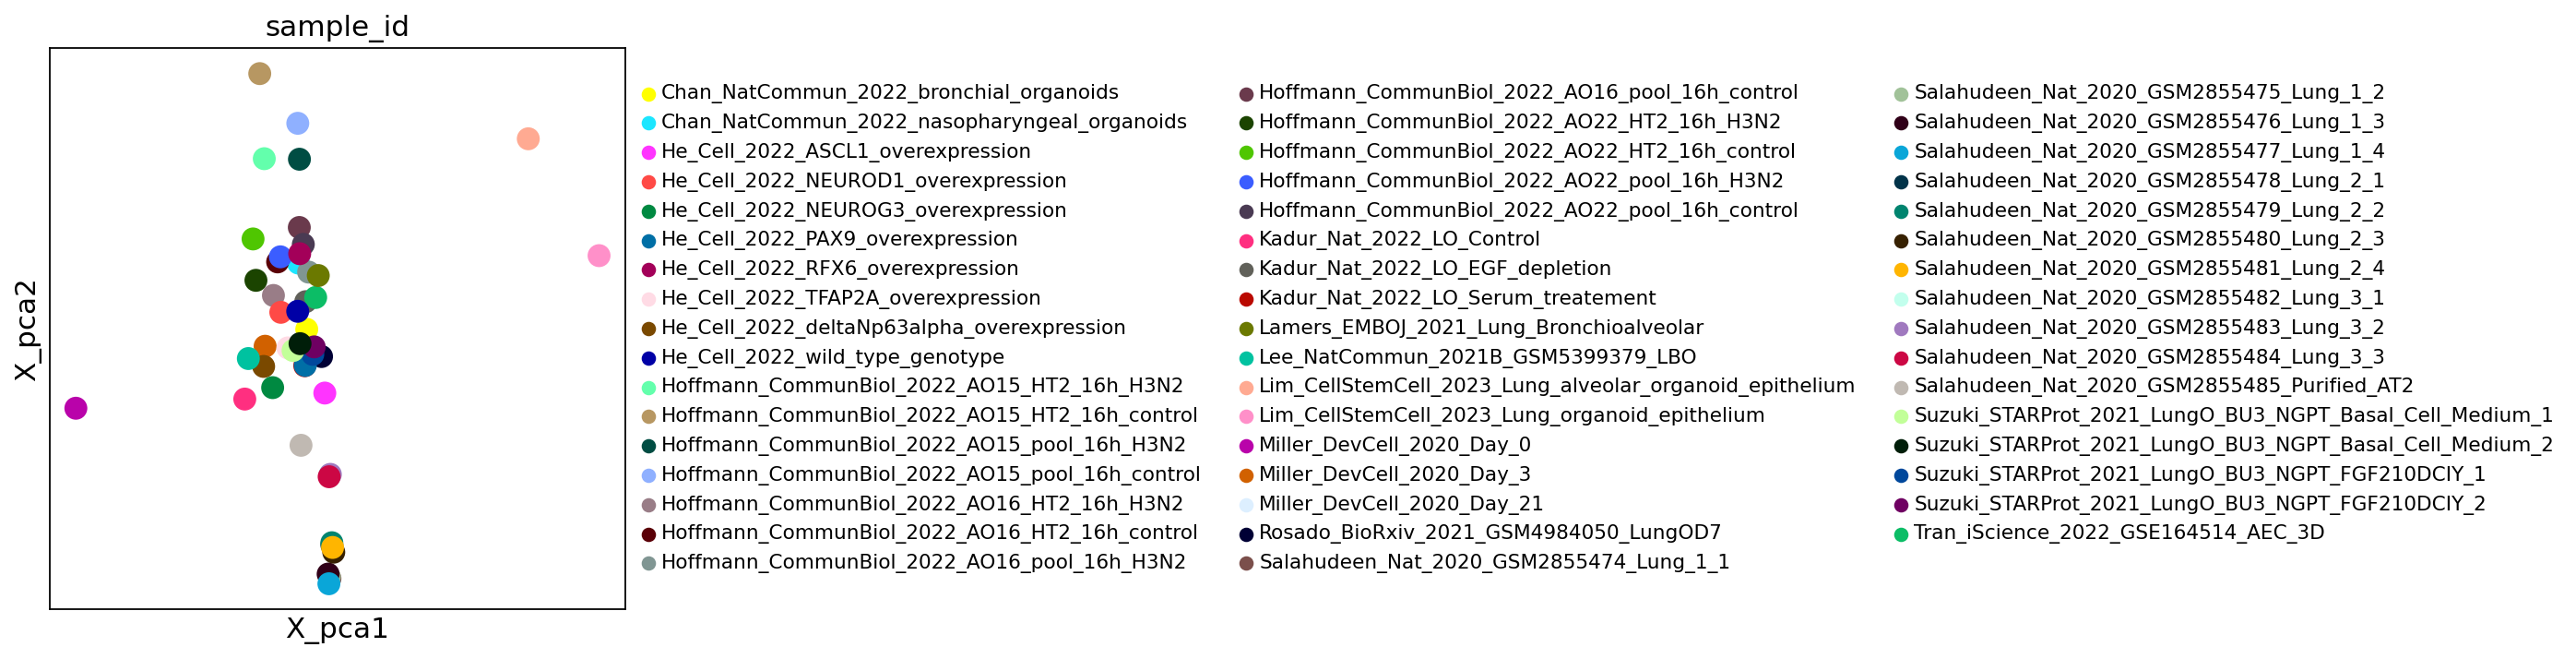

In [31]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['1,2'],
          color=['sample_id'], 
                size = 500,
#           ncols=4, 
          ncols=1, 
                legend_fontsize='x-small'
#           wspace = 0.75,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


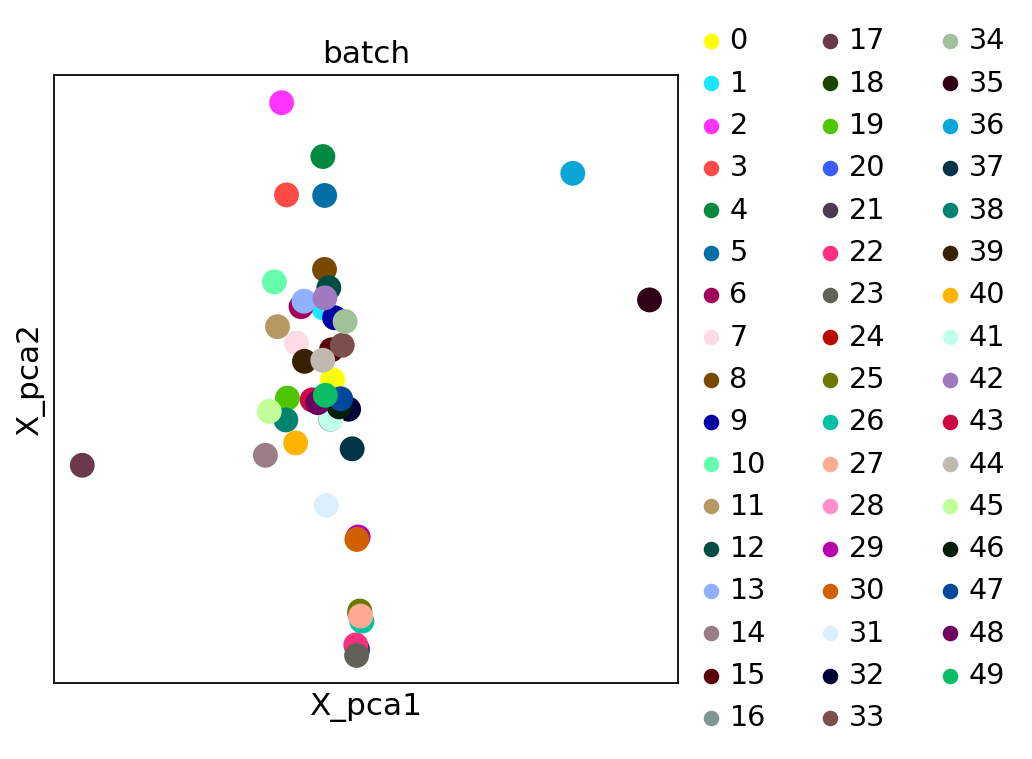

In [32]:
sc.pl.embedding(conditional_embeddings, 
                basis = 'X_pca',
          components=['1,2'],
          color=['batch'], 
                size = 500,
#           ncols=4, 
          ncols=1, 
#                 legend_fontsize='x-small'
#           wspace = 0.75,
#           legend_loc = 'bottom margin',
#           save = '_sample_embeddings_PC12_Su_covid_allCovidStates.png'
         )

### Cell embedding

In [9]:
embd = sc.AnnData(scpoli_model.get_latent(
        adata,
        mean=True
    ))

embd.obs_names = adata.obs_names
embd.obs = adata.obs.copy()

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scarches/models/scpoli/scpoli_model.py:344: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  c = torch.tensor(label_tensor, device=device).T


In [10]:
# Add proliferation/cell cycle markers

adata_ = sc.read('../../fetal_lung/lung_organoid_epithelial.h5ad')
markers = ['E2F1','MYBL2','BUB1','PLK1','CCNE1','CCND1','CCNB1']
markers = [x for x in markers if x in adata_.var_names]

adata_markers = adata_[:, adata_.var_names.isin(markers) ].copy()
sc.pp.normalize_total(adata_markers, target_sum=1e6)
sc.pp.log1p(adata_markers)
adata_markers = adata_markers.to_df()
embd.obs = pd.concat((embd.obs, adata_markers), axis = 1)

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [11]:
sc.pp.neighbors(embd)
sc.tl.umap(embd)

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python

In [12]:
sc.set_figure_params(figsize=(4, 4))

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


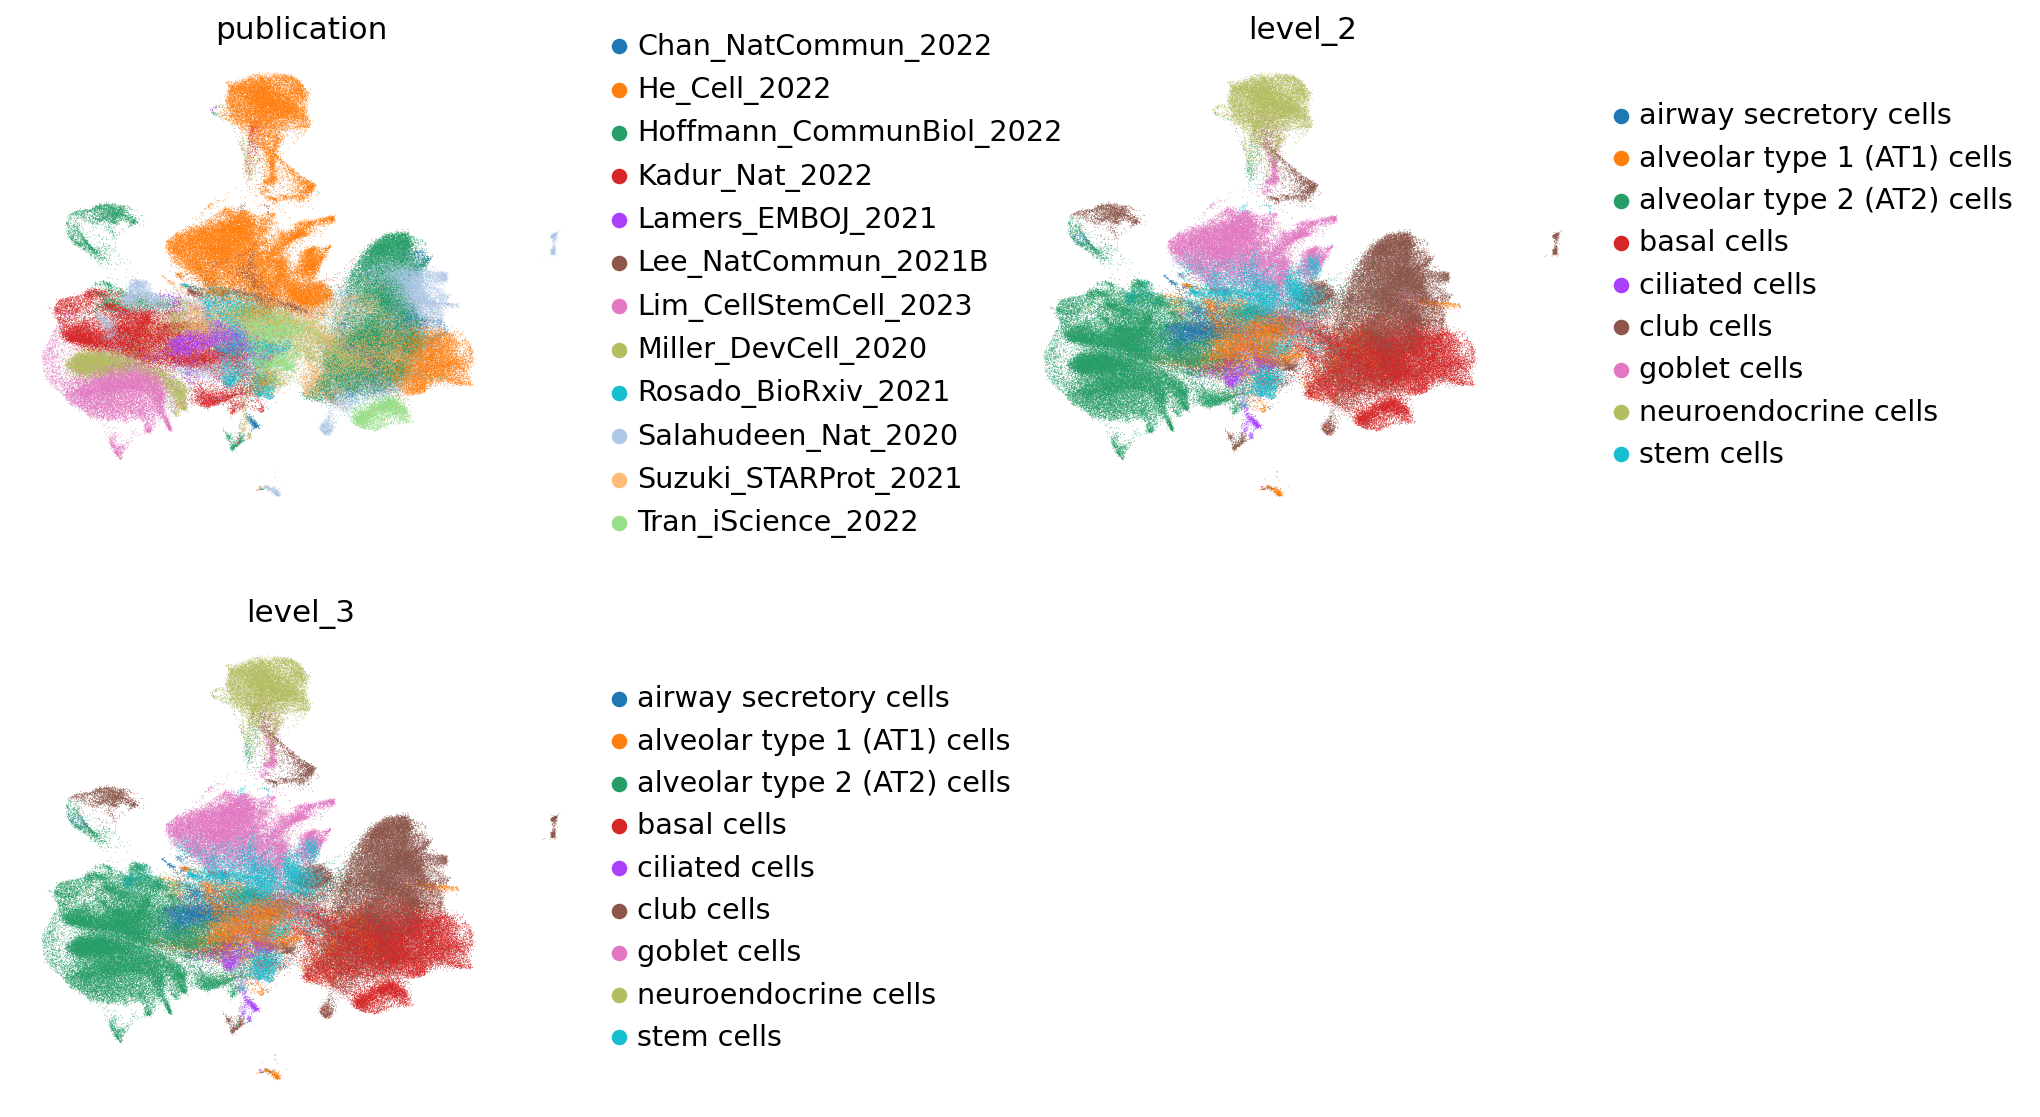

In [13]:
sc.pl.umap(embd, color=["publication", "level_2", "level_3"], 
                            wspace = 0.6, ncols=2, frameon=False, show=True)

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


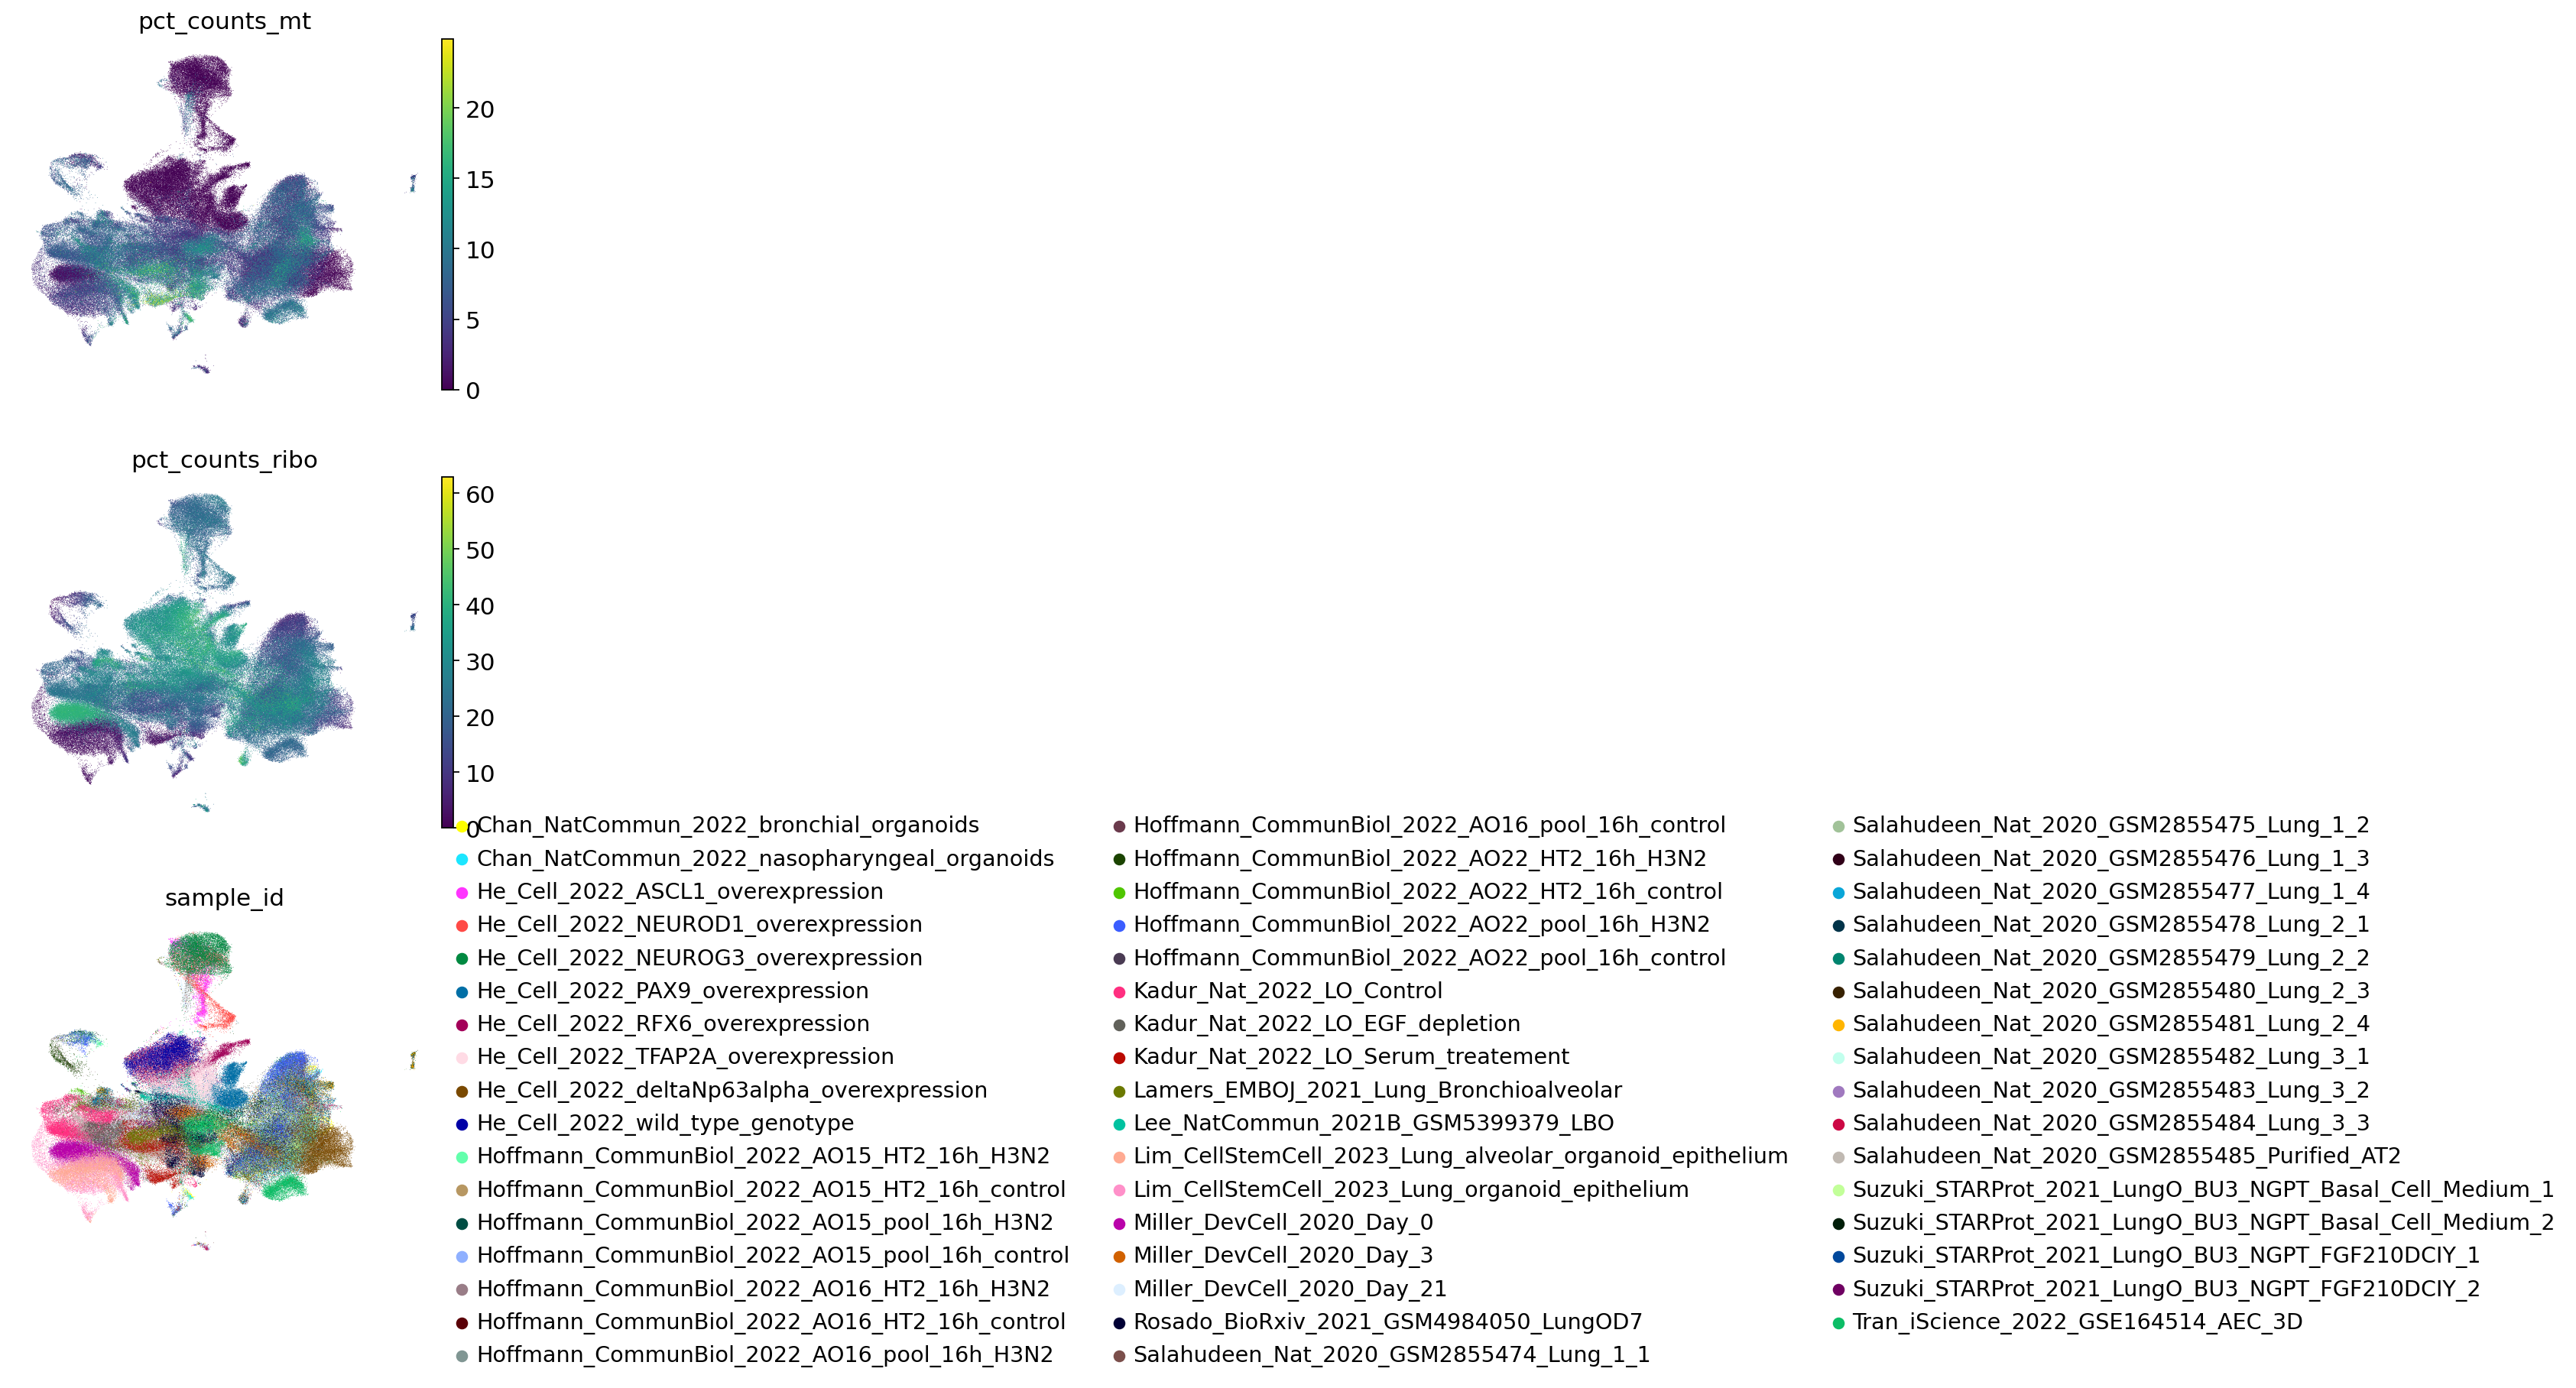

In [16]:
sc.pl.umap(embd, color=['pct_counts_mt',  'pct_counts_ribo', 'sample_id'], 
                            ncols=1, frameon=False, show=True)

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


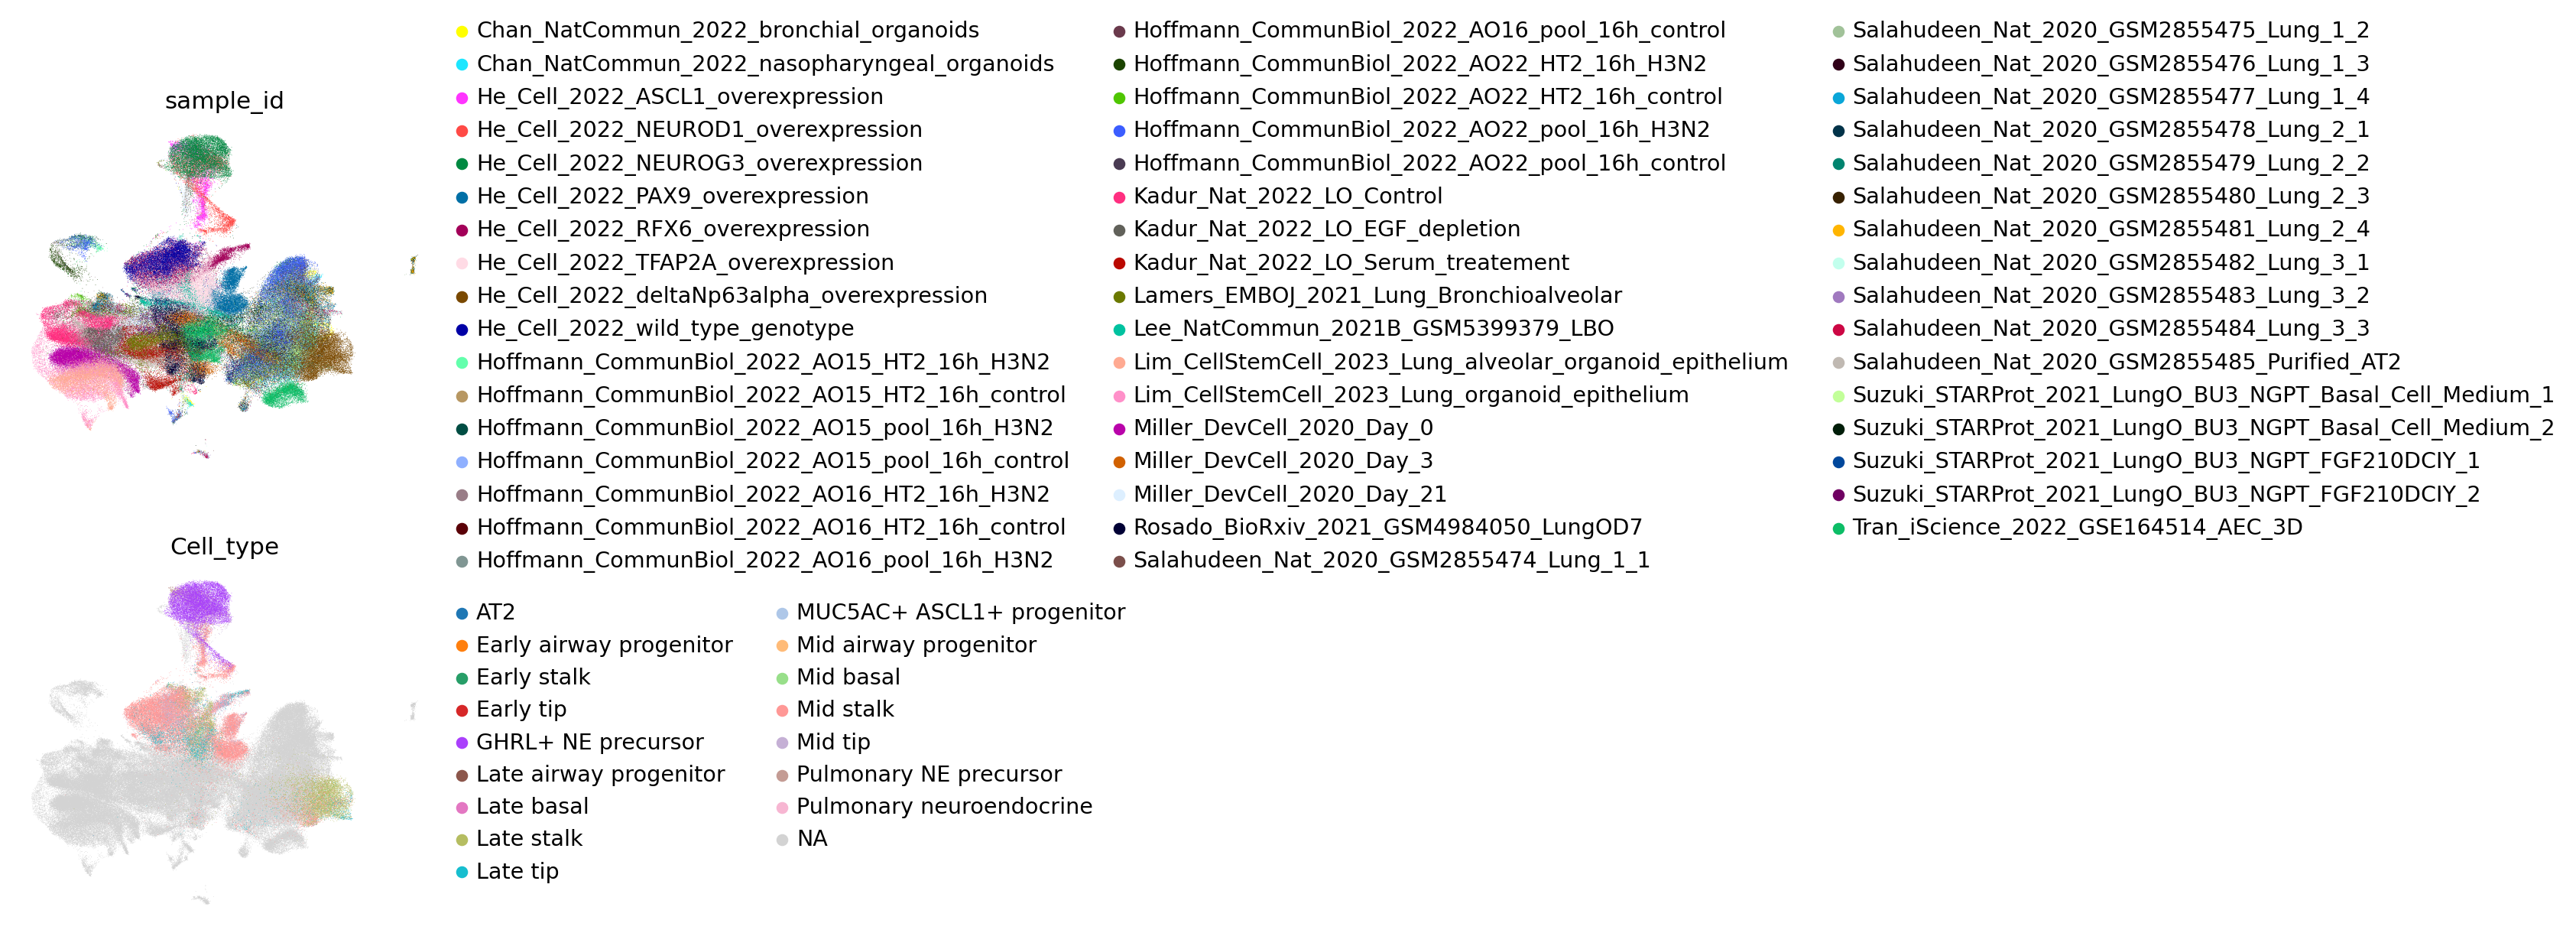

In [15]:
sc.pl.umap(embd, color=['sample_id', 'Cell_type'], 
                            ncols=1, frameon=False, show=True)

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


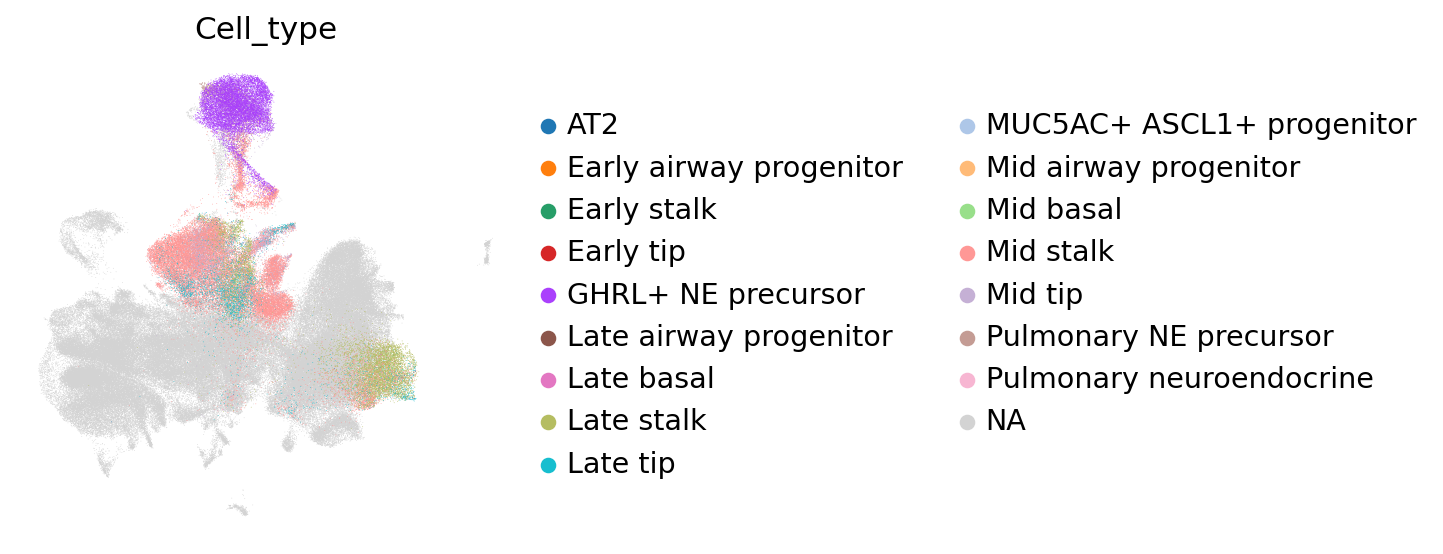

In [17]:
sc.pl.umap(embd, color=['Cell_type'], 
                            ncols=1, frameon=False, show=True)

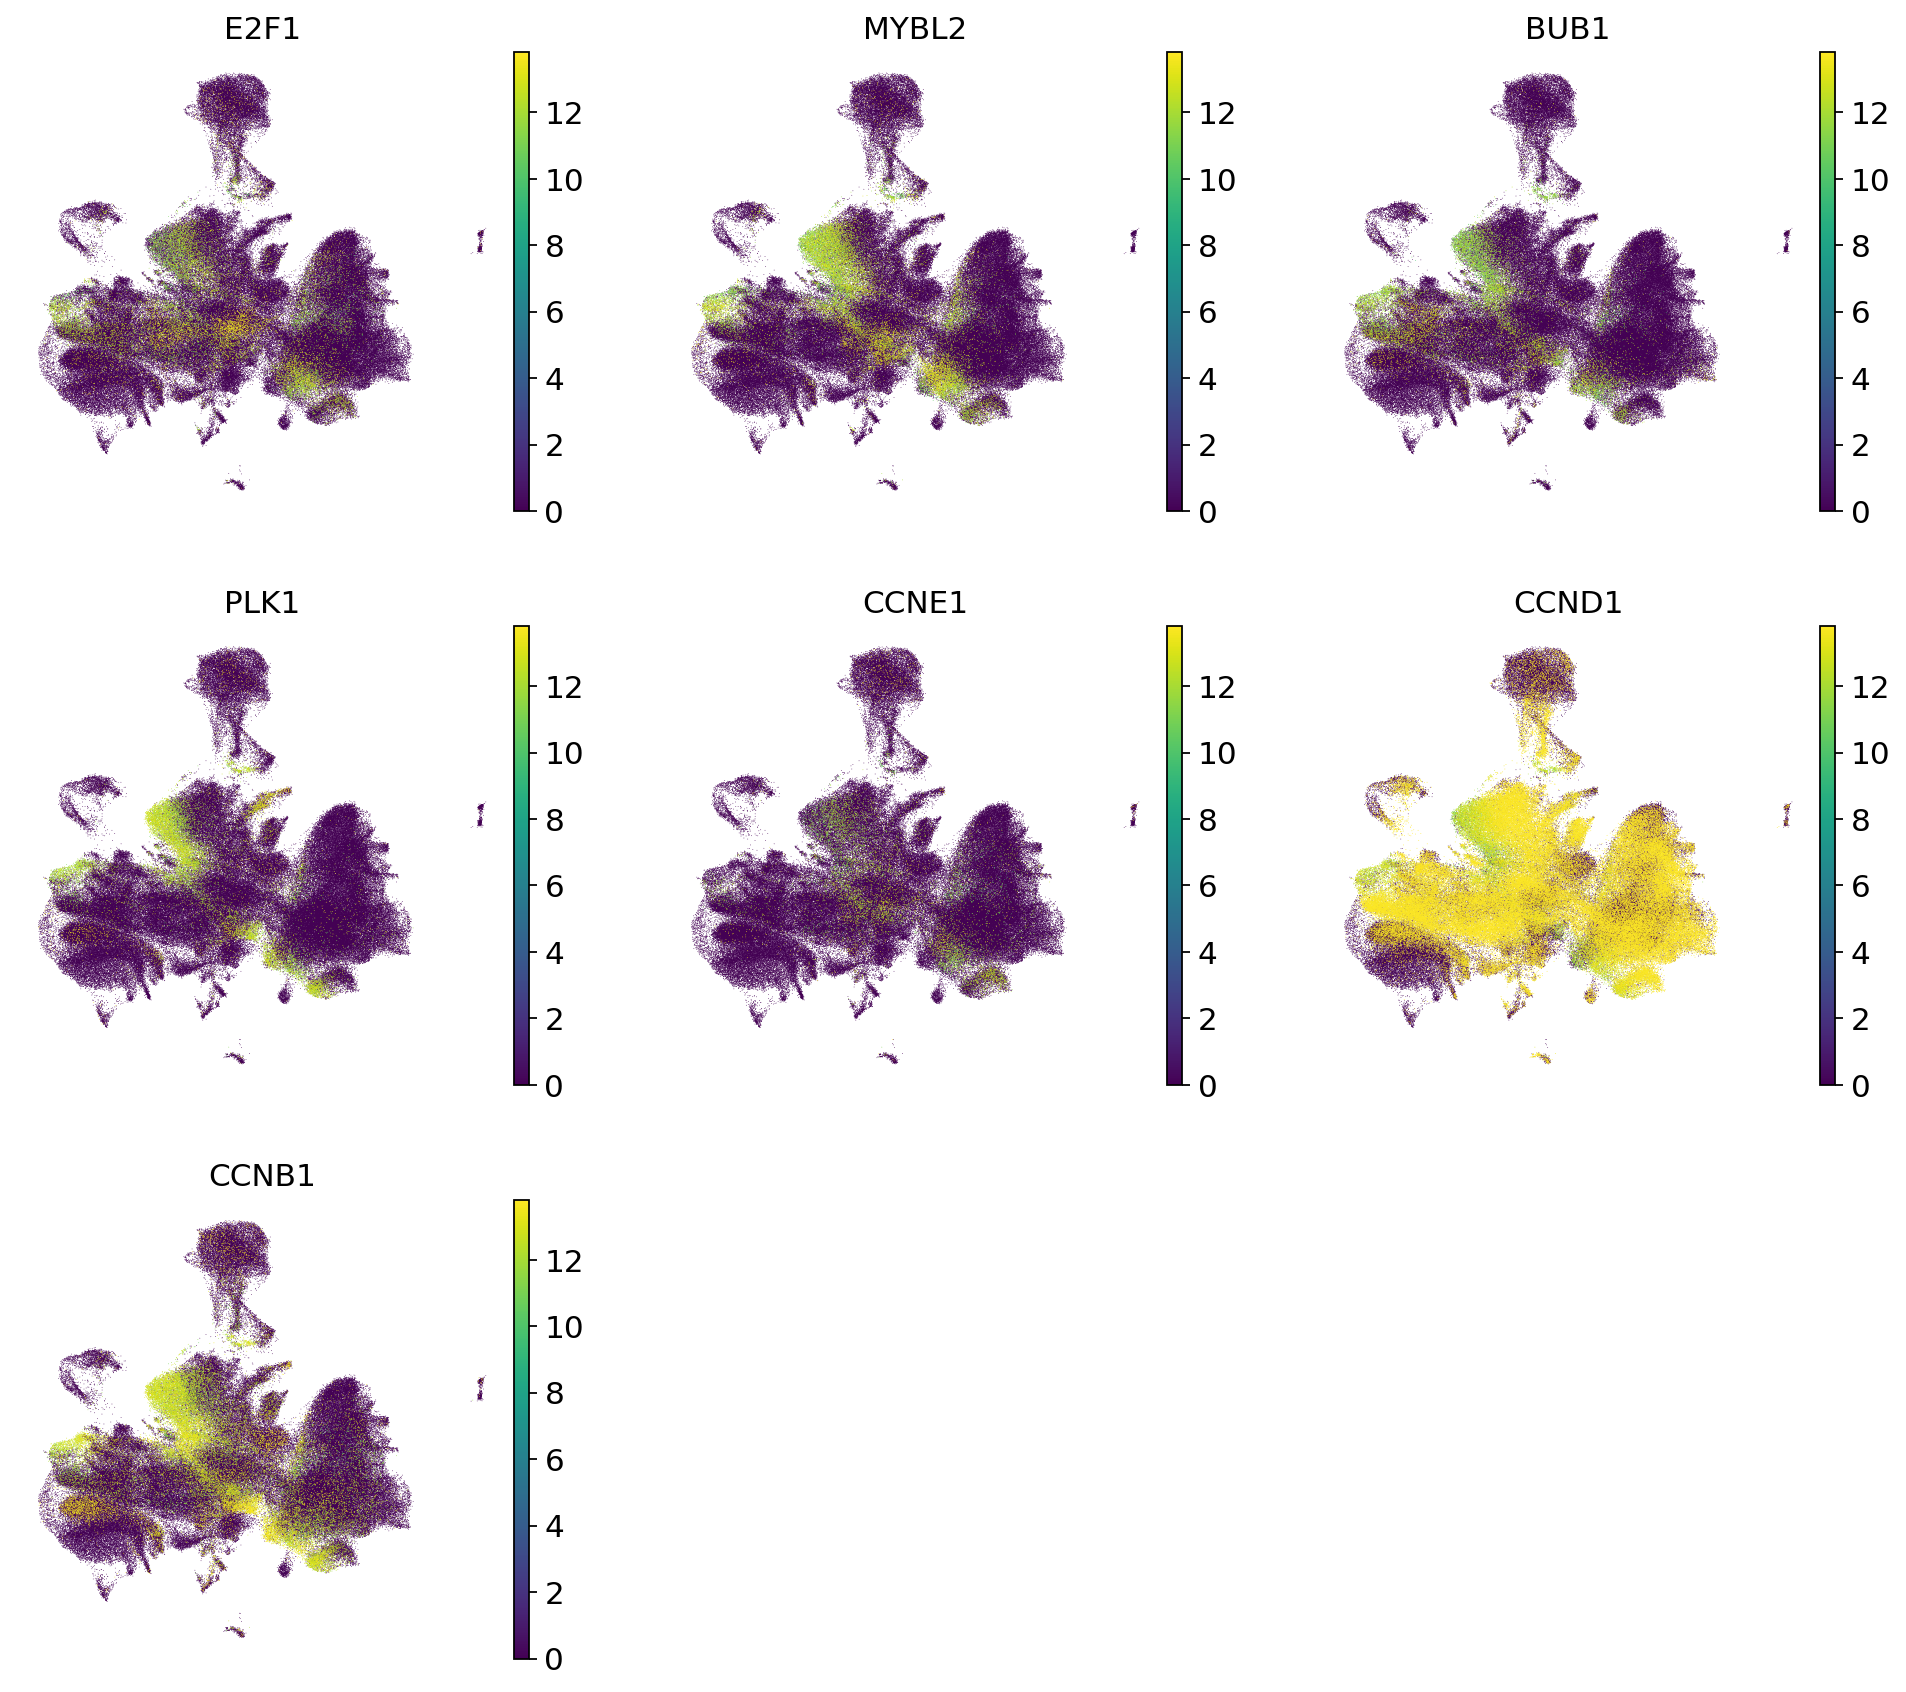

In [18]:
# proliferation/cell cycle markers
sc.pl.umap(embd, color=markers, 
                            ncols=3, frameon=False, show=True)

In [21]:
# add metadata to cell embedding for export
sample_data =  sample_data.reindex(adata.obs.sample_id)
sample_data.index = embd.obs_names
embd.obs = pd.concat((embd.obs, sample_data), axis = 1)

/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/theislab/l_zadeh/.conda/envs/scarches/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


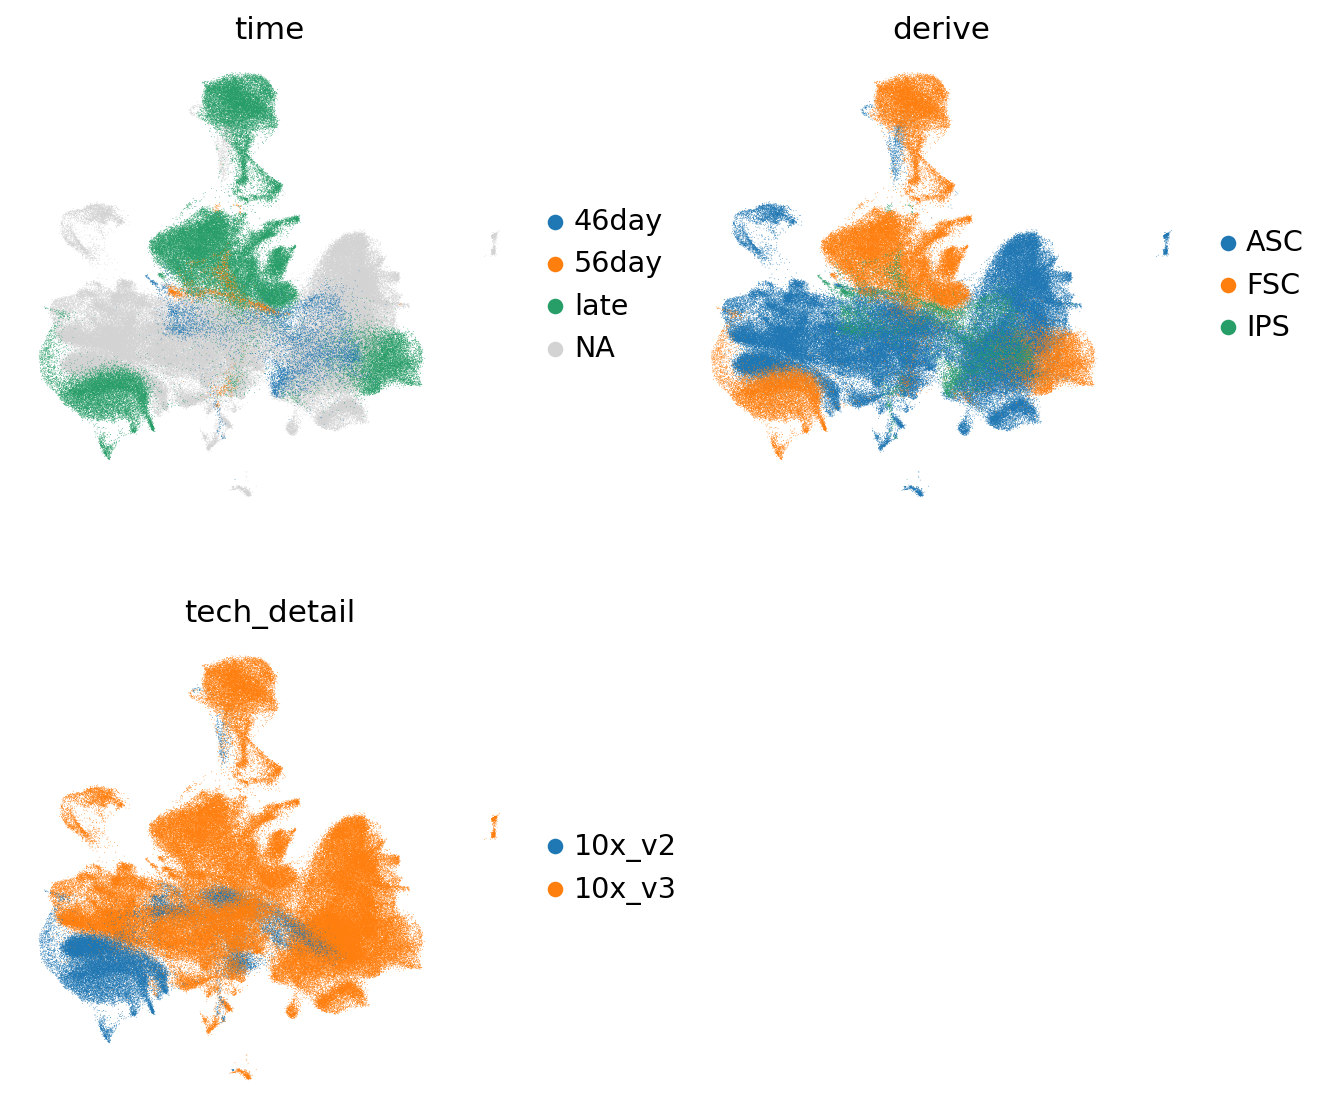

In [22]:
sc.pl.umap(embd, color=['time', 'derive', 'tech_detail'], 
                            ncols=2, frameon=False, show=True)

In [34]:
# embd.obs['conditions_combined'] = embd.obs.conditions_combined.astype('str')
embd.obs['main_cells'] = embd.obs.main_cells.astype('str')
embd.obs['protocol'] = embd.obs.protocol.astype('str')
embd.obs['molecular'] = embd.obs.molecular.astype('str')
embd.obs['gel'] = embd.obs.gel.astype('str')

In [37]:
embd.write('embeddings/epithelial_lung_organoid_latent__model__scpoli_integration_lung_organoid_sampelD_as_batch_2kFeatures.h5ad')